In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm

from google.colab import drive
drive.mount('/content/drive')

lifestyle_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sleep_health_and_lifestyle_dataset.csv')
lifestyle_df.head()

#Choosing a dataset related to sleep, health, lifestyle.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [149]:

x = lifestyle_df['Sleep Duration'].values.reshape(-1,1)[:1000]
y = lifestyle_df['Stress Level'].values.reshape(-1)[:1000]

model = LinearRegression().fit(x, y)

coefficient of determination:  0.6577583517744219
Mean squared error: 1.074818269032034


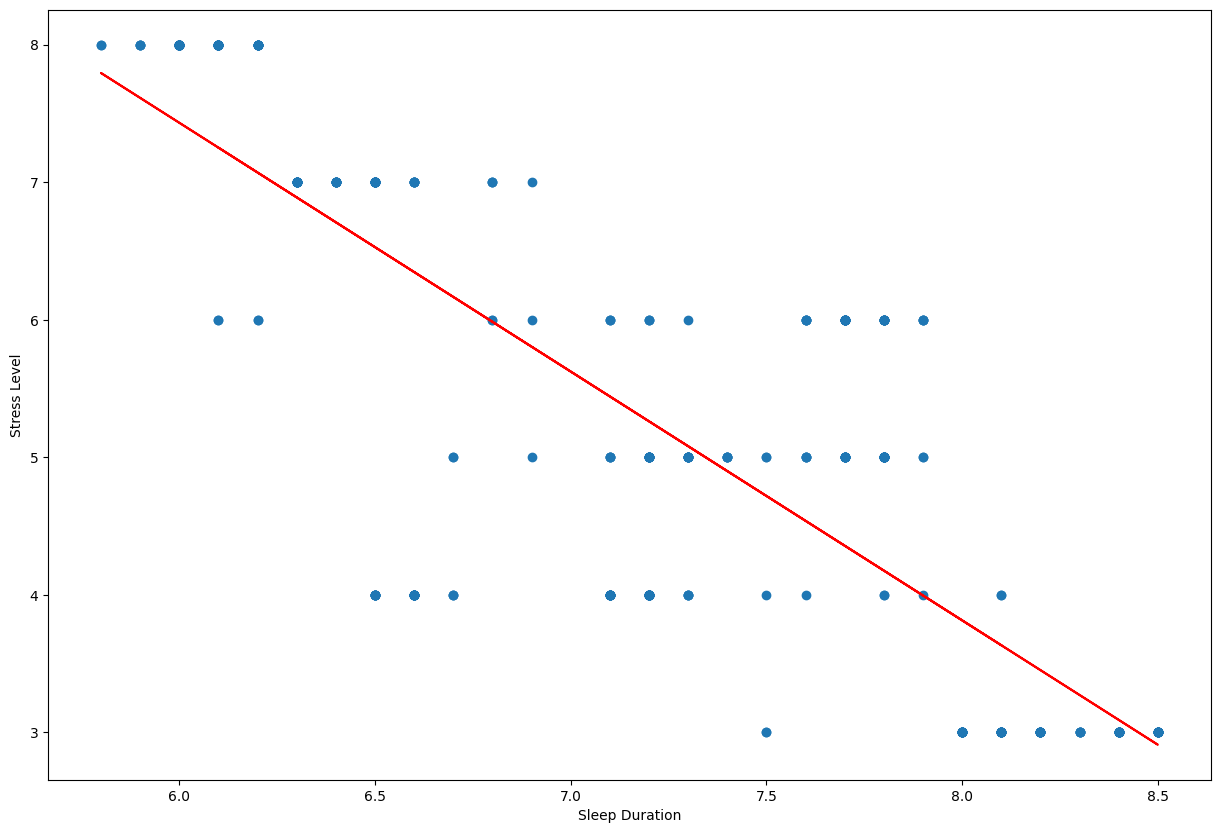

In [150]:

plt.figure(figsize = (15,10))
plt.scatter(x, y)
plt.xlabel("Sleep Duration")
plt.ylabel("Stress Level")
plt.plot(x, (x*model.coef_ + model.intercept_), "r")

det_coef = model.score(x, y)
print("coefficient of determination: ", det_coef)
print("Mean squared error:", mean_squared_error(y, (x*model.coef_+model.intercept_)))

plt.show()

#Plotting relation between sleep duration and stress level. Coefficient of determination and mean squared error indicate that model could fit the data better.

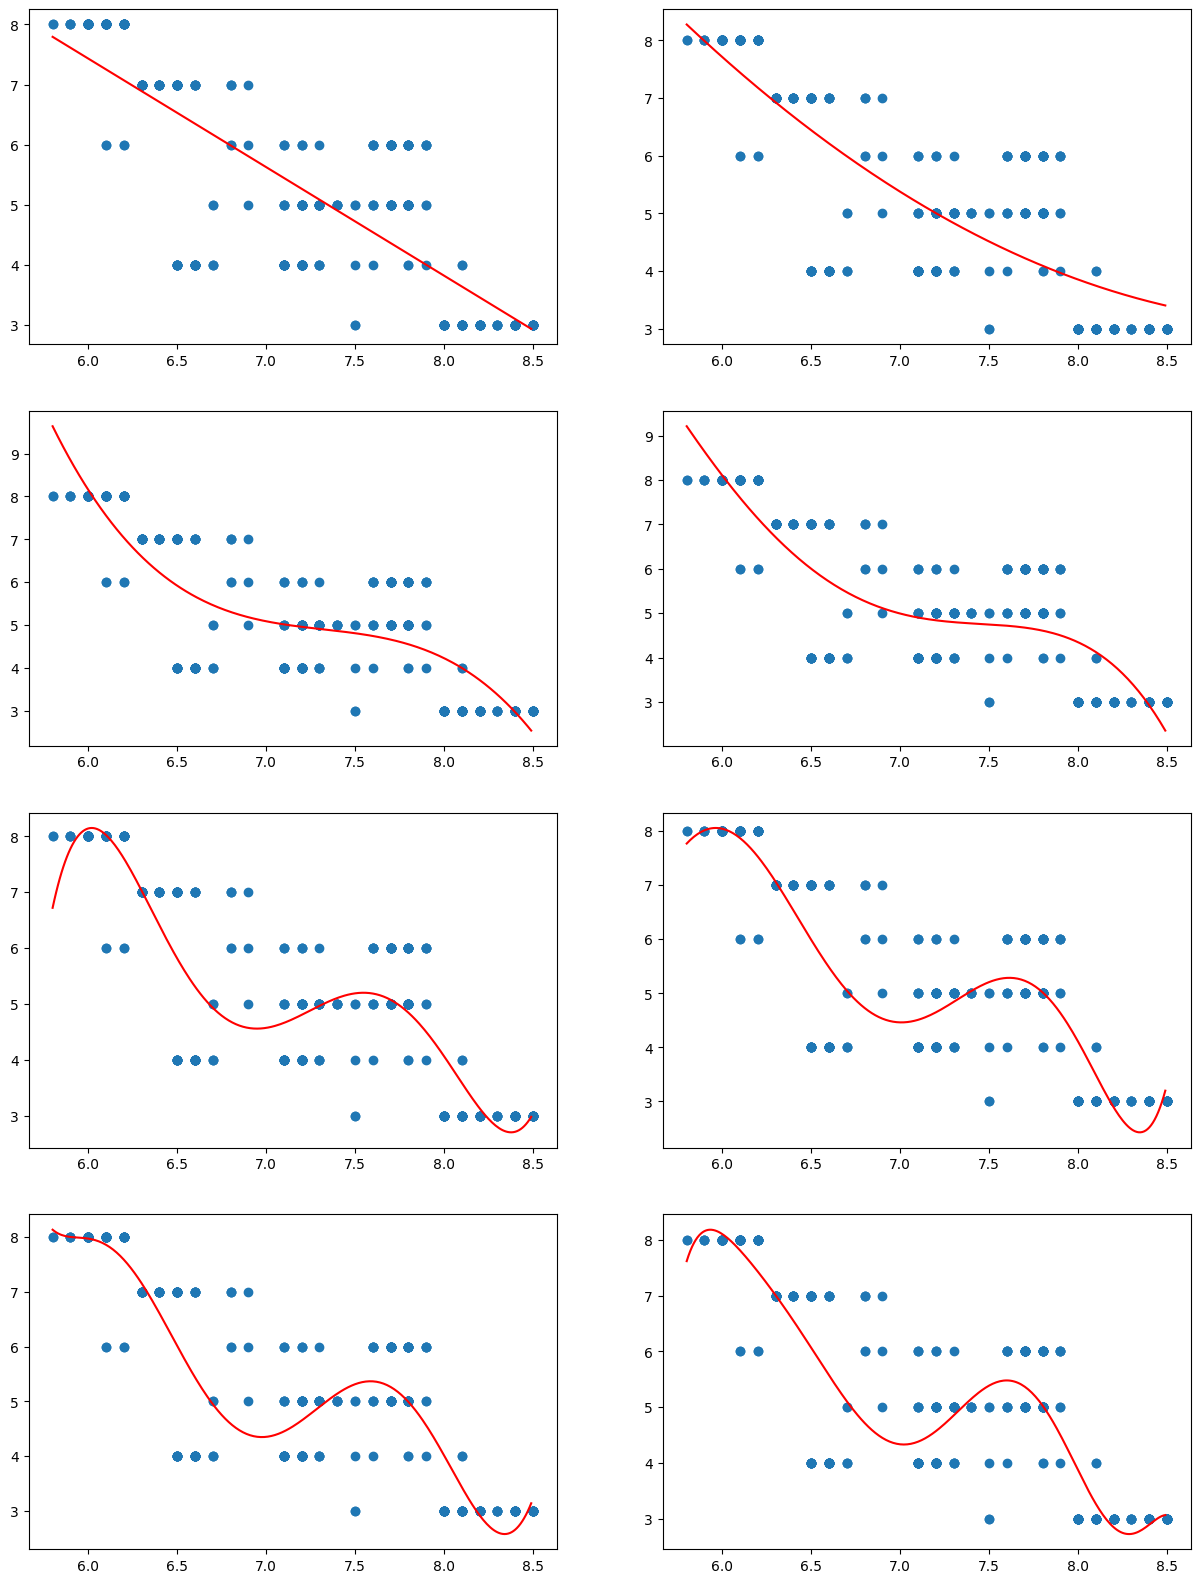

In [151]:

mean = []
plt.figure(figsize = (15,20))
#setting the step to 0.01 since range of x vary from 6 to 8.5
x_new = np.arange(x.min(), x.max(), 0.01).reshape(-1,1)

for order in range(1,9):

    poly = PolynomialFeatures(order, include_bias = False)
    x_order = poly.fit_transform(x)

    model = LinearRegression().fit(x_order, y)
    y_pred = model.predict(poly.fit_transform(x_new))

    ax = plt.subplot(4, 2, order)
    ax = plt.scatter(x, y)
    ax = plt.plot(x_new, y_pred, color="red")
    mean.append(mean_squared_error(y, model.predict(x_order)))

#We can notice that trying to fit model with higher polynomial degree seems to overcomplicate the problem. Considering the data, relation between stress level and sleeping time is probably
#no more than quadratic, or even linear, and we just should try to fit the linear function better (finding the optimal slope and bias).


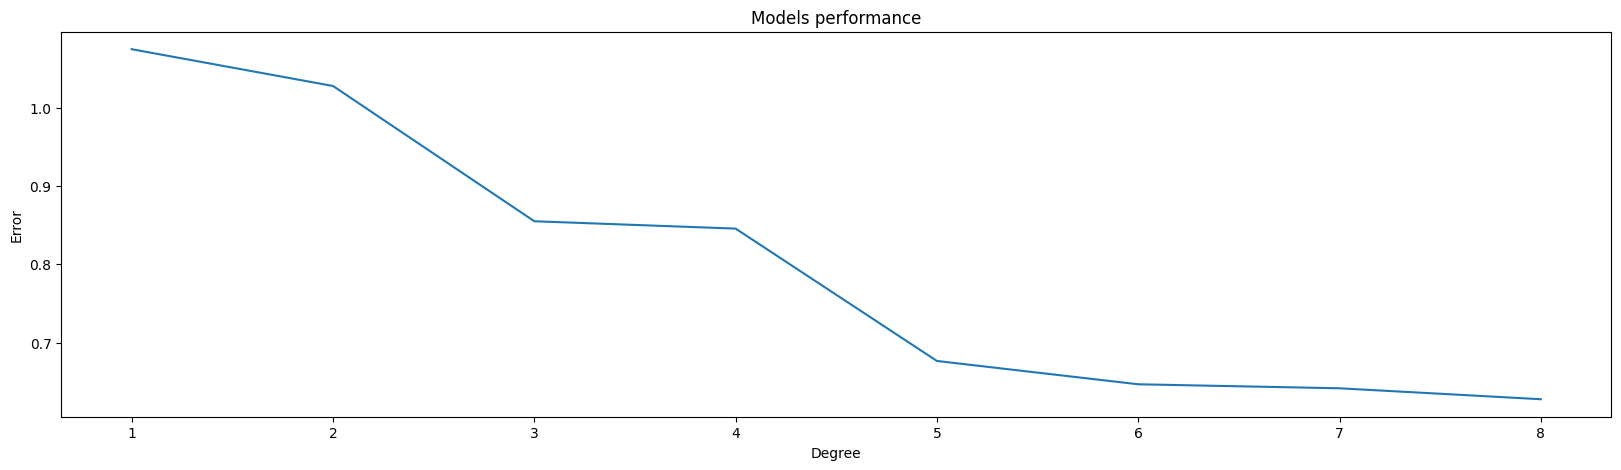

In [152]:
degree = [1,2,3,4,5,6,7,8]
plt.figure(figsize = (20,5))
plt.xlabel("Degree")
plt.ylabel("Error")
plt.title("Models performance")
plt.plot(degree, mean)

#We can notice that the higher polynomial degree, the smaller the error is, with flattening between 3 and 4 degree
#(caused by the fact that the 3rd and 4th degree polynomial in this case are very similar and so error is).

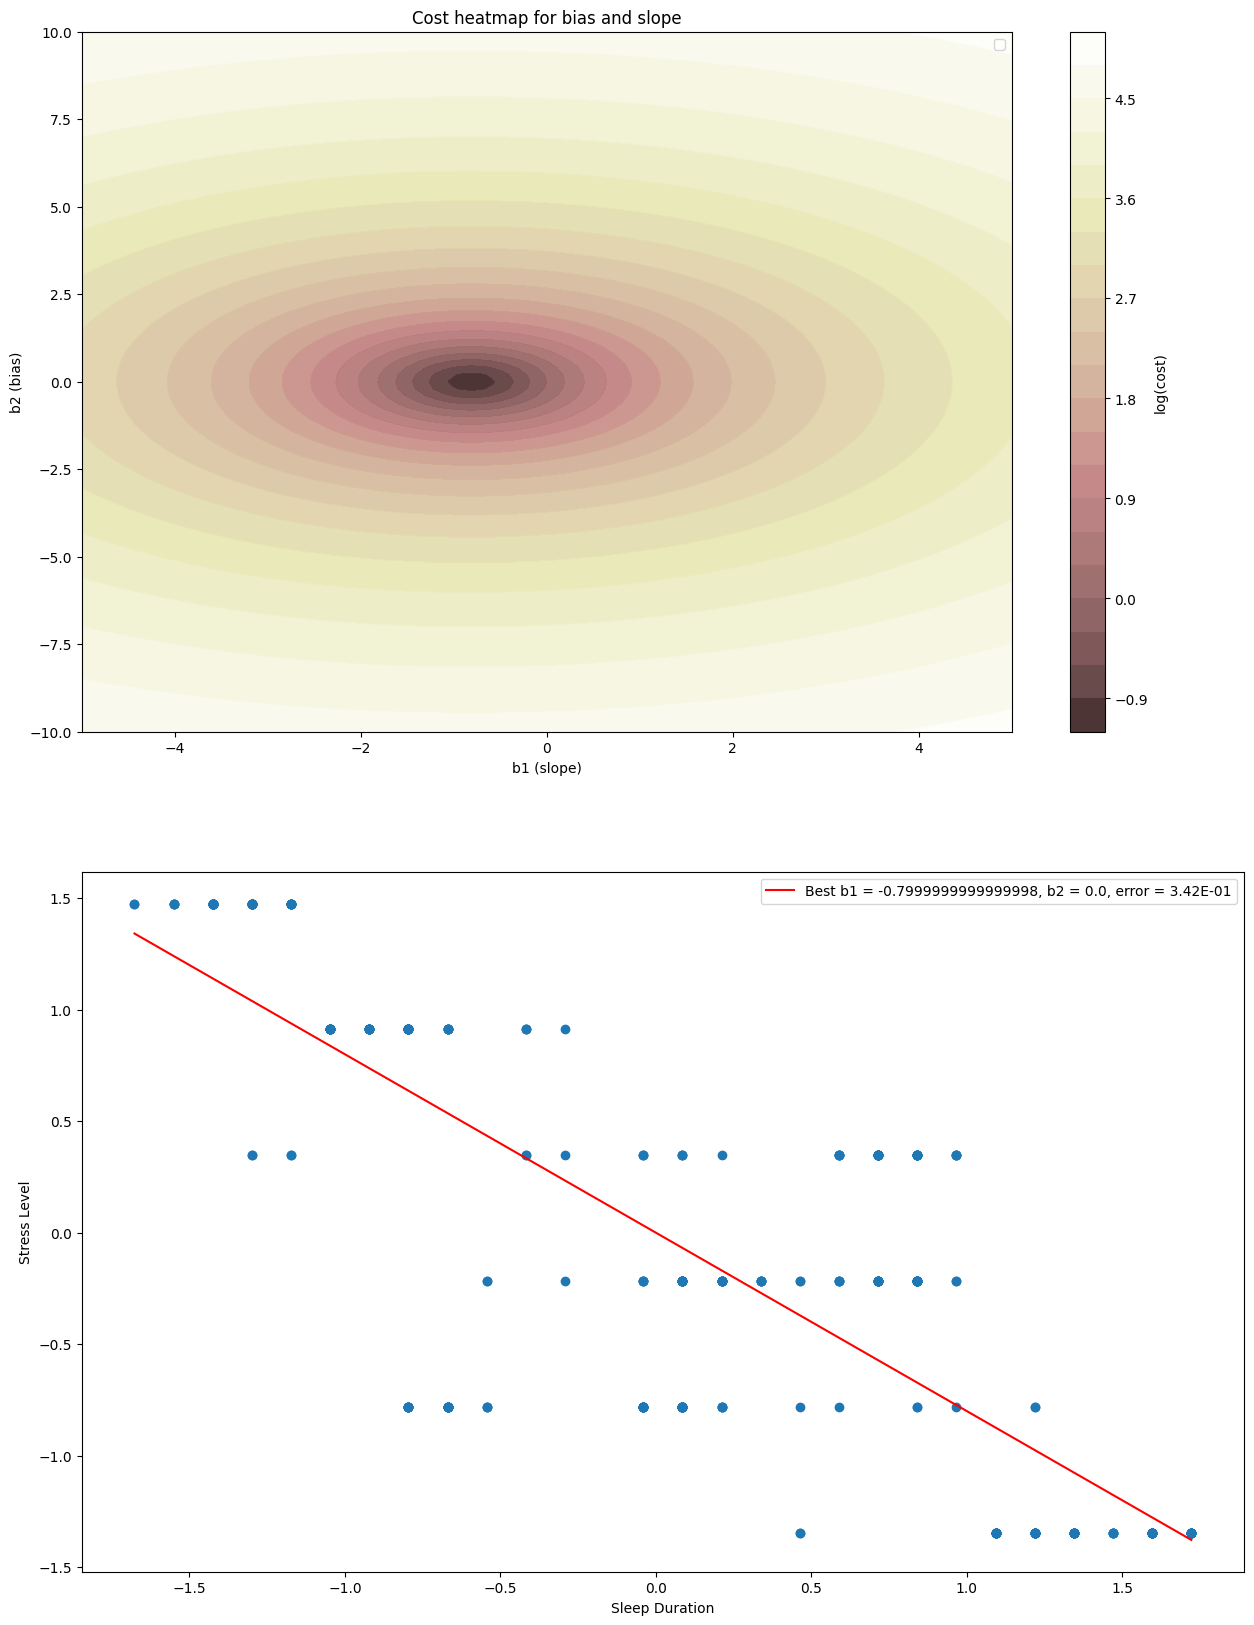

Mean squared error: 0.3423631553695309


In [158]:
#Trying to fit linear model with best slope and bias and comparing its mean squared error to polynomial ones and for fitted linear one.

x = lifestyle_df['Sleep Duration'].values.reshape(-1,1)[:1000]
y = lifestyle_df['Stress Level'].values.reshape(-1)[:1000]

def standardize(X):
    means = np.mean(X, axis=0)
    sds = np.std(X, axis=0)
    return (X - means) / sds, means, sds

def destandardize(X, means, sds):
    return (X * sds) + means

def predict(b, X):
    y_pred = np.dot(X,b)
    return y_pred

def cost(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)

x, mean, sds = standardize(x)
y, meanY, sdsY = standardize(y)

#creating a bias column with a size of columns of matrix x (filled with ones)
bias = np.ones(x.shape[0]).reshape(-1,1)
#appending that column to x as a column (defining axis = 1)
x = np.append(x, bias, axis=1)


nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-5, 5, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-10, 10, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), x) , y)


plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
plt.title("Cost heatmap for bias and slope")

plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

plt.subplot(2,1,2)

plt.scatter(x.T[0], y)
plt.xlabel("Sleep Duration")
plt.ylabel("Stress Level")

best_b1_2d_ind, best_b2_2d_ind = np.unravel_index(cost_arr_2d.argmin(), cost_arr_2d.shape)
best_b1 = b_x[best_b1_2d_ind,best_b2_2d_ind]
best_b2 = b_y[best_b1_2d_ind,best_b2_2d_ind]


x_model = np.linspace(np.min(x), np.max(x), 1000)
y_model = best_b1*x_model + best_b2
plt.plot(x_model, y_model, label='Best b1 = {}, b2 = {}, error = {:.2E}'.format(best_b1, best_b2, cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind]), color = "r")

plt.legend()

plt.show()

print("Mean squared error:", cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind])

#Computed error is equal 0.34 now, which is way less then for fitted linear function, 1.07.
#It is comparable with error for high polynomial functions, but the linear is more accurate and realistic for this particular case, so we probably should use it.

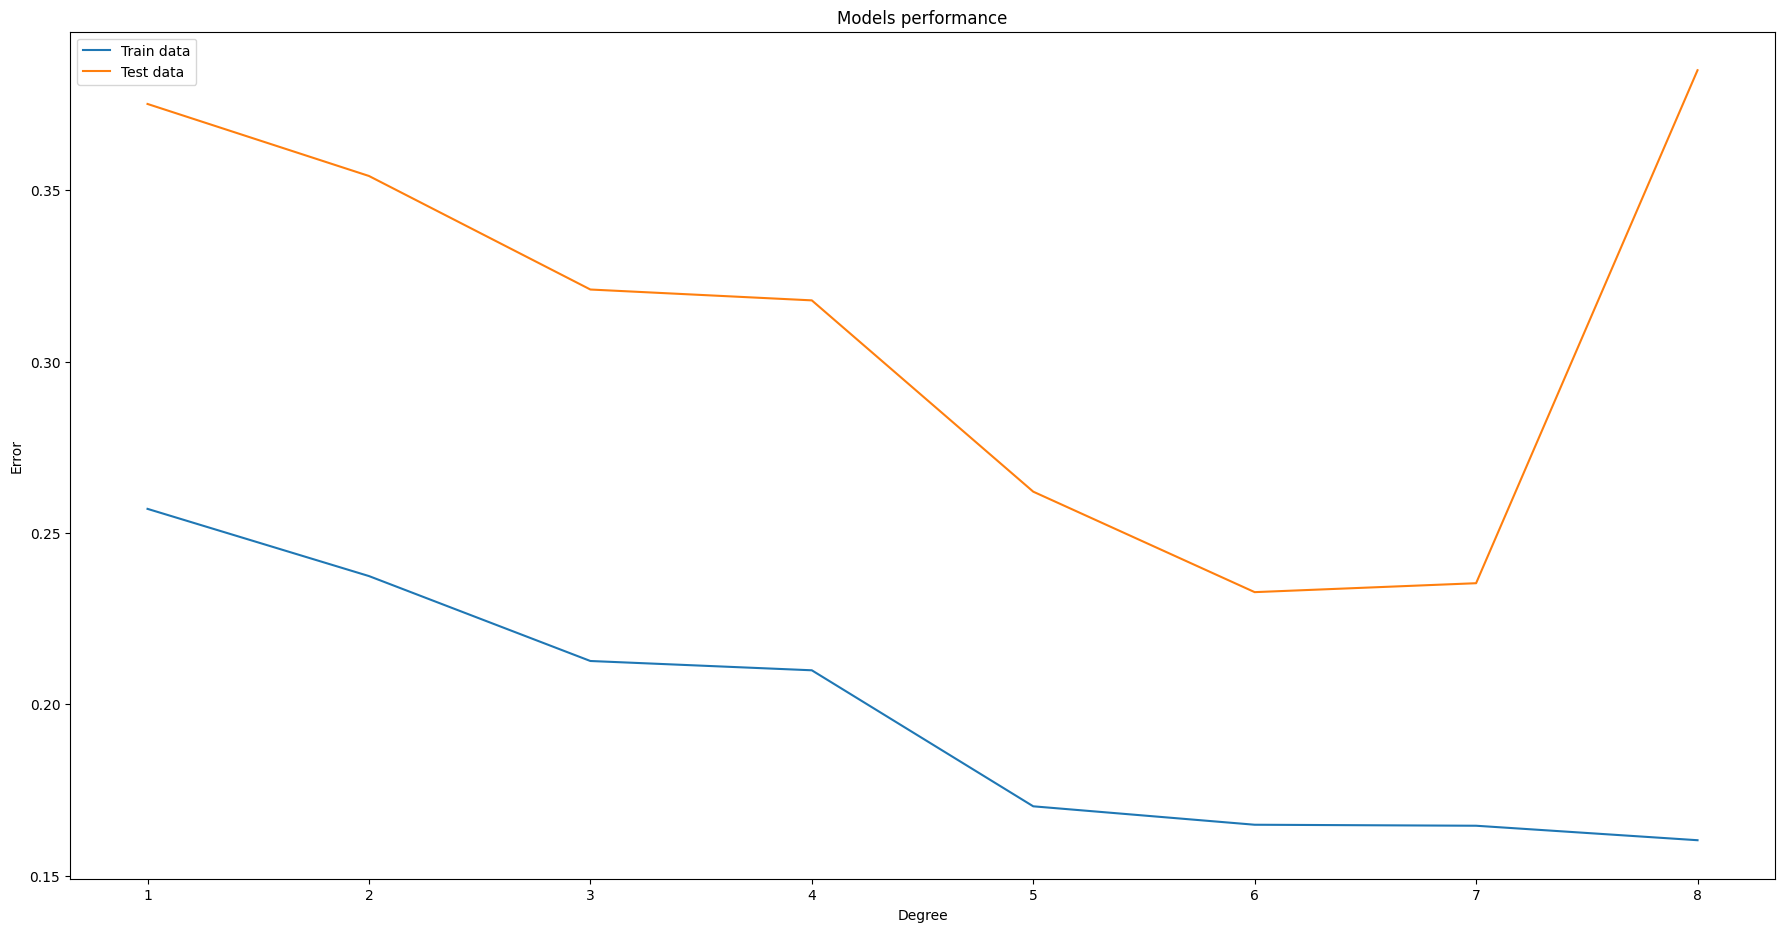

In [154]:
#Models performance with data split

train_errors = []
test_errors = []

for order in range(1,9):

    poly = PolynomialFeatures(order, include_bias = False)
    x_order = poly.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x_order, y, test_size=0.9, random_state=44)

    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict (x_train)
    train_errors.append(mean_squared_error(y_train, y_pred))

    y2_pred = model.predict (x_test)
    #checking how good our model is on the test data
    test_errors.append(mean_squared_error(y_test, y2_pred))

plt.figure(figsize = (22,11))
plt.xlabel("Degree")
plt.ylabel("Error")
plt.title("Models performance")
plt.plot(degree, train_errors, label = "Train data")
plt.plot(degree, test_errors, label = "Test data")

plt.legend(loc="upper left")

#Suprisingly, even with splitting train and test data that test data size is 0.9 of all data, test data error is decreasing until the polynomial degree is 6.
#It might be caused by the fact that data pool is quite small in compare to average database size.

coefficient of determination: 0.03490505822417467
Mean squared error: 3.030904275237007


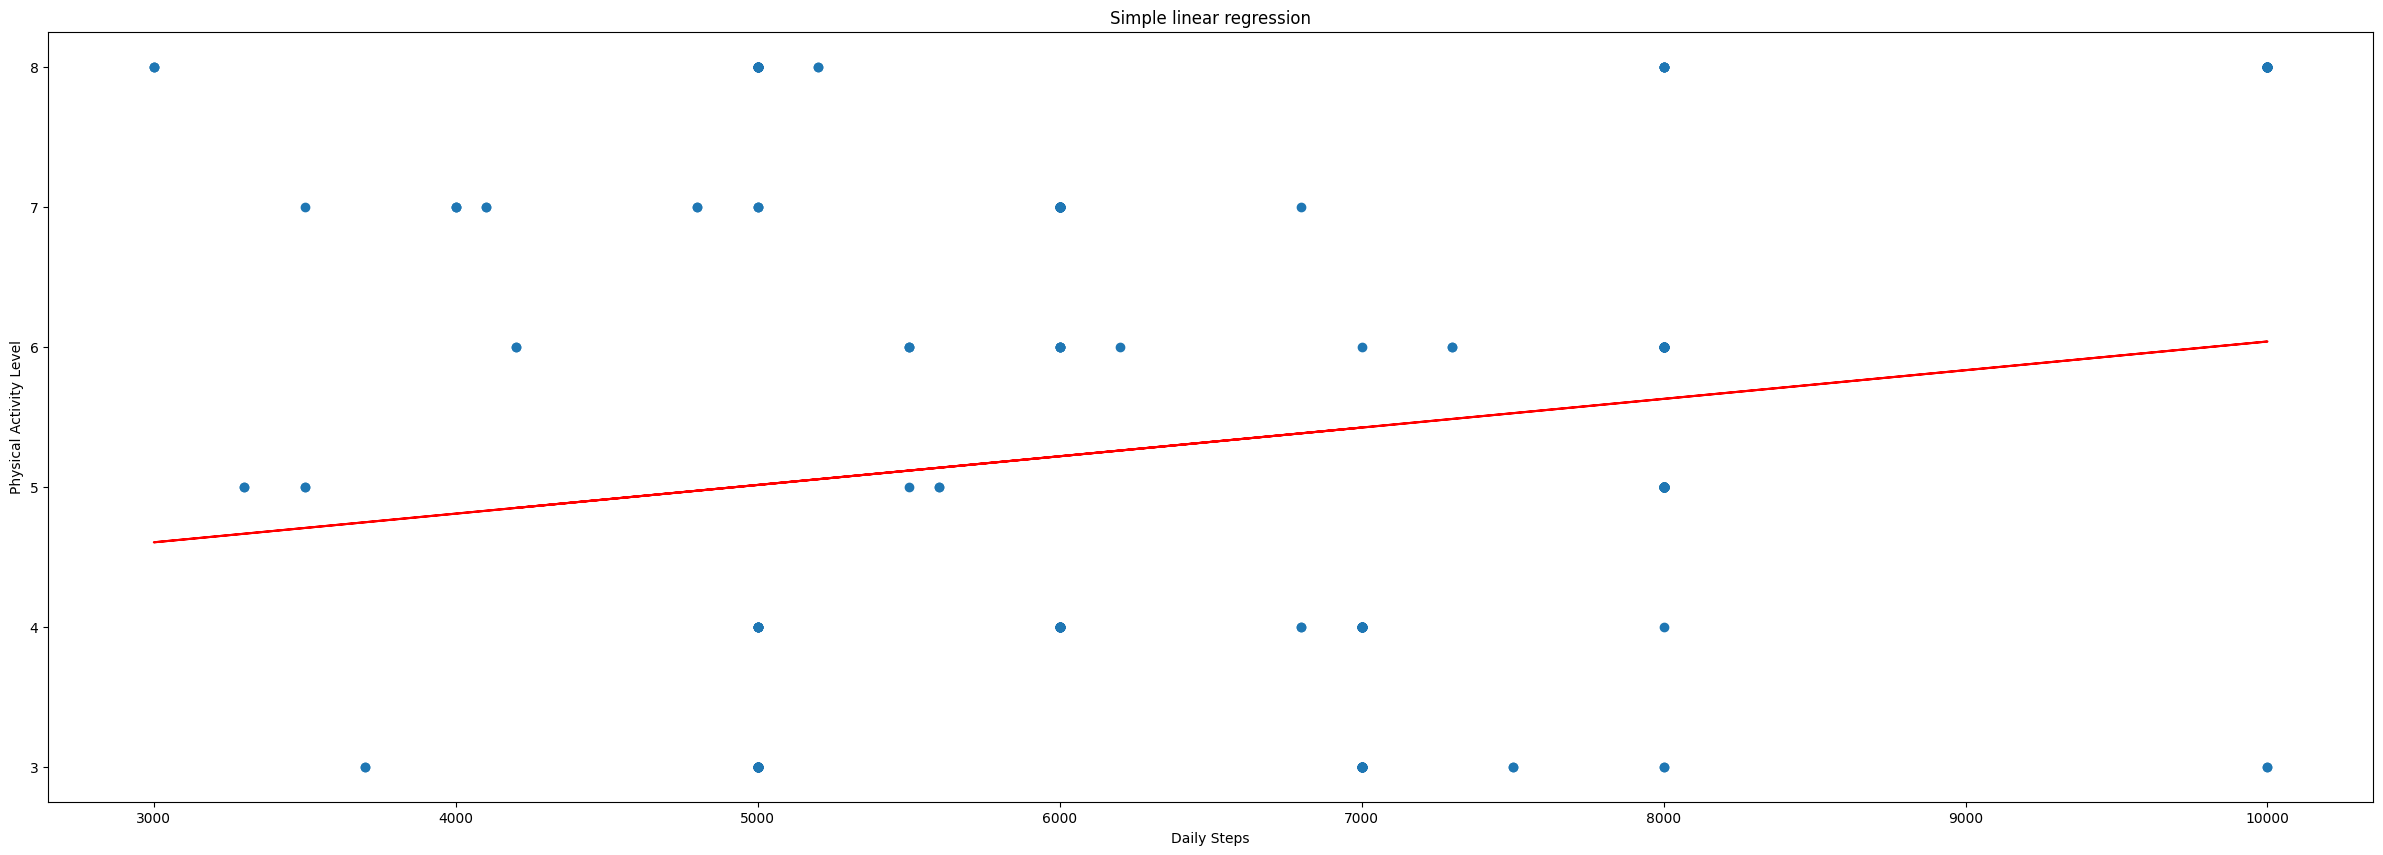

In [155]:

x = lifestyle_df["Daily Steps"].values.reshape(-1,1)[:1000]
y = lifestyle_df["Stress Level"].values.reshape(-1)[:1000]

model = LinearRegression().fit(x, y)

plt.figure(figsize = (30,10))
plt.scatter(x, y)
plt.ylabel("Physical Activity Level")
plt.xlabel("Daily Steps")
plt.title("Simple linear regression")
plt.plot(x, (x*model.coef_ + model.intercept_), "r")

det_coef = model.score(x, y)
print(f"coefficient of determination: {det_coef}")
print("Mean squared error:", mean_squared_error(y, (x*model.coef_+model.intercept_)))

plt.show()


In [156]:
#Adding more features to the model

#(1)

X = lifestyle_df[['Daily Steps', 'Physical Activity Level', 'Heart Rate', 'Age']].values.reshape(-1,4)
y = lifestyle_df["Stress Level"].values.reshape(-1)

poly = PolynomialFeatures(3, include_bias = False)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=44)

model = LinearRegression()
_= model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean squared error for first equals: {0}".format(mean_squared_error(y_pred, y_test)))

#(2)

X = lifestyle_df[['Daily Steps', 'Physical Activity Level', 'Heart Rate', 'Age', 'Quality of Sleep', 'Sleep Duration']].values.reshape(-1,6)
y = lifestyle_df["Stress Level"].values.reshape(-1)

poly = PolynomialFeatures(3, include_bias = False)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=44)

model = LinearRegression()
_= model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean squared error for first equals: {0}".format(mean_squared_error(y_pred, y_test)))



#after adding features "quality of sleep" and "sleep duration", which are great indicators wether the person might have high level of stress or no,
#the second model improved mean squared error from 15283.87 to 79.52 (!) what is a gargantuan improvement.



Mean squared error for first equals: 15283.86997117828
Mean squared error for first equals: 79.52235869280995
